In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import cv2

from torch.utils.data import Dataset, DataLoader
import os
from template_matching_funcs import check_format_of_names
import albumentations as A

ModuleNotFoundError: No module named 'template_matching_funcs'

In [ ]:
class MyDataset(Dataset):
    def __init__(self, images_folder, 
                 idx,
                 img_transform=None, masks_transform=None):
        super(Dataset, self).__init__()
        
        self.images_folder = images_folder

        self.images_names = np.sort(os.listdir(images_folder))[idx:idx+1]     
        self.img_transform = img_transform

    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
#         item_image = cv2.imread(os.path.join(self.images_folder,
#                                             self.images_names[idx]))
#         item_image = cv2.cvtColor(item_image, cv2.COLOR_BGR2RGB)
        item_image = Image.open(os.path.join(self.images_folder,
                                            self.images_names[idx])).convert('RGB')

        
        SEED = np.random.randint(123456789)
        if self.img_transform is not None:
            random.seed(SEED)
            item_image = self.img_transform(item_image)

        return item_image

In [ ]:
trans = transforms.Compose([
#     A.Resize(288, 400, interpolation=cv2.INTER_LINEAR),
    transforms.Resize((288, 400)),
    transforms.ToTensor(),
])

path_data = '/home/e_radionova/cig5_Research_optimal_kernels/Unet_birds/'+ \
            'Caltech_birds/CUB_200_2011/dataset/train/'

train_set = MyDataset(images_folder = path_data + 'images/002.Laysan_Albatross/', 
                      idx = 11,
                      img_transform = trans, masks_transform = trans)

In [ ]:
batch_size=1
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
}

inputs = next(iter(dataloaders['train']))

dataloaders['train'].dataset.images_names

In [3]:
from template_matching_funcs import template_matching, thresholding, get_Fourier_coeffs_and_kernel

def get_kernel_baseline(image, template, order, kernel_size,
                       morph_open, morph_close, dilate):
    img_match = template_matching(image=image, template=template, method=cv2.TM_CCORR)
    img_thresh = thresholding(img_match)
    
    kern = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))  # np.ones((5,5),np.uint8)
    if morph_open:
        img_thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kern)
    if morph_close:
        img_thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kern)
    if dilate:
        img_thresh = cv2.dilate(img_thresh,kern,iterations = 1)
    
    plt.imshow(img_thresh, cmap='gray')
    plt.show()
    _, kernel = get_Fourier_coeffs_and_kernel(img_thresh, order=order, kernel_size=kernel_size)
    
    return kernel

## First conv

### Conv 1.1

### Original case

In [5]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

in_channels = 3
out_channels = 64

conv_first_1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
relu = nn.ReLU(inplace=True)
feature_map1 = conv_first_1(inputs)
feature_map1 = relu(feature_map1)
print(feature_map1.shape)

fig, ax = plt.subplots(feature_map1.shape[1]//4, 4, figsize=(15, 60))
for i in range(feature_map1.shape[1]):
    ax[i//4, i%4].imshow(feature_map1.detach().numpy()[0][i:i+1,:,:].transpose(1, 2, 0))
    ax[i//4, i%4].set_title(f'Layer {i}')


### Our case

In [ ]:
template_mask = Image.open(path_data + 'masks/002.Laysan_Albatross/Laysan_Albatross_0050_870.png')
width, height = template_mask.size
template_mask = template_mask.resize((25, int(25 * height/width)),Image.ANTIALIAS)

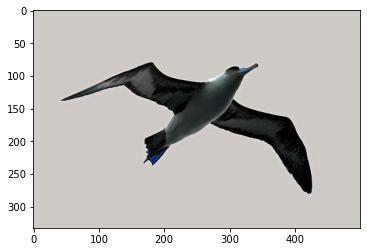

(333, 500, 3)


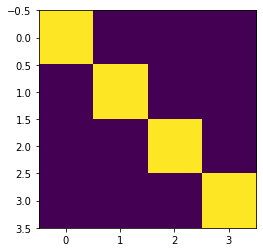

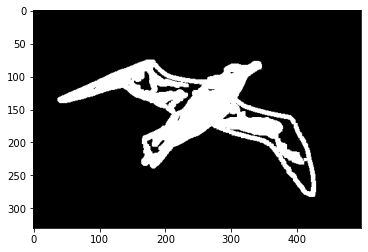

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


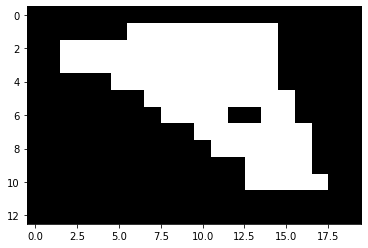

In [33]:
# for i in range(3,4): #feature_map1.shape[1]):
#     fm = feature_map1.detach().numpy()[0][i:i+1,:,:].transpose(1,2,0)
# fm = np.array(inputs[0].permute(1,2,0))
path_data = '/home/e_radionova/cig5_Research_optimal_kernels/Unet_birds/'+ \
            'Caltech_birds/CUB_200_2011/dataset/train/'
fm = cv2.imread(path_data + 'images/002.Laysan_Albatross/Laysan_Albatross_0050_870.jpg')
plt.imshow(fm, cmap='gray')
plt.show()
# fm = fm.astype(np.float32)
print(fm.shape)
template1 = np.array([[1., 0., 0., 0.],
                     [0., 1., 0., 0.],
                     [0., 0., 1., 0.],
                     [0., 0., 0., 1.]])

plt.imshow(template1)
plt.show()

kernel_per_img = get_kernel_baseline(image=fm, 
                                    template=template1, 
                                    order=10, 
                                    kernel_size=20,
                                    morph_open=False, 
                                    morph_close=False, 
                                    dilate=True)
plt.imshow(kernel_per_img)
plt.show()

### Conv 1.2

In [8]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

in_channels = 64
out_channels = 64

conv_first_2 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
relu = nn.ReLU(inplace=True)
feature_map2 = conv_first_2(feature_map1)
feature_map2 = relu(feature_map2)
print(feature_map2.shape)

fig, ax = plt.subplots(feature_map2.shape[1]//4, 4, figsize=(15, 60))
for i in range(feature_map2.shape[1]):
    ax[i//4, i%4].imshow(feature_map2.detach().numpy()[0][i:i+1,:,:].transpose(1, 2, 0))
    ax[i//4, i%4].set_title(f'Layer {i}')

## Second conv

In [9]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

in_channels = 64
out_channels = 128

conv_second_1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
relu = nn.ReLU(inplace=True)
feature_map3 = conv_second_1(feature_map2)
feature_map3 = relu(feature_map3)
print(feature_map3.shape)

fig, ax = plt.subplots(feature_map3.shape[1]//4, 4, figsize=(15, 120))
for i in range(feature_map3.shape[1]):
    ax[i//4, i%4].imshow(feature_map3.detach().numpy()[0][i:i+1,:,:].transpose(1, 2, 0))
    ax[i//4, i%4].set_title(f'Layer {i}')

In [10]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

in_channels = 128
out_channels = 128

conv_second_2 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
relu = nn.ReLU(inplace=True)
feature_map4 = conv_second_2(feature_map3)
feature_map4 = relu(feature_map4)
print(feature_map4.shape)

fig, ax = plt.subplots(feature_map4.shape[1]//4, 4, figsize=(15, 120))
for i in range(feature_map4.shape[1]):
    ax[i//4, i%4].imshow(feature_map4.detach().numpy()[0][i:i+1,:,:].transpose(1, 2, 0))
    ax[i//4, i%4].set_title(f'Layer {i}')

## Third conv

In [11]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

in_channels = 128
out_channels = 256

conv_third_1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
relu = nn.ReLU(inplace=True)
feature_map5 = conv_third_1(feature_map4)
feature_map5 = relu(feature_map5)
print(feature_map5.shape)

fig, ax = plt.subplots(feature_map5.shape[1]//4, 4, figsize=(15, 240))
for i in range(feature_map5.shape[1]):
    ax[i//4, i%4].imshow(feature_map5.detach().numpy()[0][i:i+1,:,:].transpose(1, 2, 0))
    ax[i//4, i%4].set_title(f'Layer {i}')


In [12]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

in_channels = 256
out_channels = 256

conv_third_2 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
relu = nn.ReLU(inplace=True)
feature_map6 = conv_third_2(feature_map5)
feature_map6 = relu(feature_map6)
print(feature_map6.shape)

fig, ax = plt.subplots(feature_map6.shape[1]//4, 4, figsize=(15, 240))
for i in range(feature_map6.shape[1]):
    ax[i//4, i%4].imshow(feature_map6.detach().numpy()[0][i:i+1,:,:].transpose(1, 2, 0))
    ax[i//4, i%4].set_title(f'Layer {i}')

## Fourth conv

In [13]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

in_channels = 256
out_channels = 512

conv_fourth_1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
relu = nn.ReLU(inplace=True)
feature_map7 = conv_fourth_1(feature_map6)
feature_map7 = relu(feature_map7)
print(feature_map7.shape)

fig, ax = plt.subplots(feature_map7.shape[1]//4, 4, figsize=(15, 480))
for i in range(feature_map7.shape[1]):
    ax[i//4, i%4].imshow(feature_map7.detach().numpy()[0][i:i+1,:,:].transpose(1, 2, 0))
    ax[i//4, i%4].set_title(f'Layer {i}')

In [14]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

in_channels = 512
out_channels = 512

conv_fourth_2 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
relu = nn.ReLU(inplace=True)
feature_map8 = conv_fourth_2(feature_map7)
feature_map8 = relu(feature_map8)
print(feature_map8.shape)

fig, ax = plt.subplots(feature_map8.shape[1]//4, 4, figsize=(15, 480))
for i in range(feature_map8.shape[1]):
    ax[i//4, i%4].imshow(feature_map8.detach().numpy()[0][i:i+1,:,:].transpose(1, 2, 0))
    ax[i//4, i%4].set_title(f'Layer {i}')